In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import sf_utils

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statannotations.Annotator import Annotator


import seaborn as sns

sc.settings.set_figure_params(dpi=80, facecolor='white', fontsize=14, scanpy=True, format='pdf')
sc.set_figure_params(figsize=(5,5))

sc.settings.verbosity=3

# Create a clone-cell embedding for HSC RNA and ATAC datasets

In [3]:
#load CCA embedding (available on Figshare)
adata_mult = sc.read_h5ad("../proc_files/lsk_mult_coemb.h5ad")

In [5]:
#load clone table
clone_table = pd.read_csv("../../hsc.rna&atac.r1&2_master_v2.csv", index_col=0)

In [6]:
clone_table.loc[clone_table['cell_type2'].isin(["MEP","MPP","MPP/GMP"]), 'cell_type2'] = 'na'
clone_table.loc[clone_table['cell_type2'].isin(["Unk_1","Unk_2","Unk_3"]), 'cell_type2'] = 'na'
len(list(clone_table[(clone_table['day']=='d5') & (clone_table['cell_type2']!='na')].groupby('clone.id')))

5718

In [7]:
#assign new fates (merging lym and DCs) - only for coembed analysis
clone_table.loc[clone_table.cell_type2.isin(['Lym','pDC','Ccr7_DC']), 'cell_type2'] = 'Lym/DC'
clone_table.drop(columns=['fate','fate_pct'], inplace=True)

def assign_fate(clone_mtx):
    clone_mtx_curr = clone_mtx[clone_mtx['day'] == 'd5'].copy()
    if(len(clone_mtx_curr) == 0):
        clone_mtx['fate'] = 'no_fate_cells'
        clone_mtx['fate_pct'] = 0
    else:
        clone_mtx['fate'] = clone_mtx_curr['cell_type2'].value_counts(dropna=False).sort_index().idxmax()
        clone_mtx['fate_pct'] = 100*clone_mtx_curr['cell_type2'].value_counts(dropna=False).sort_index().max()/len(clone_mtx_curr)
    return clone_mtx


new_table = pd.DataFrame()

for _,i in clone_table.groupby("clone.id"):
    clone_curr = assign_fate(i).copy()
    new_table = pd.concat((new_table,clone_curr))

In [8]:
new_table['fate']

clone.id
1       no_fate_cells
1       no_fate_cells
2                  na
2                  na
2                  na
            ...      
6820             Mono
6821               na
6821               na
6822             Mono
6822             Mono
Name: fate, Length: 44349, dtype: object

In [47]:
#prepare data for CCE
new_table['clone_id'] = new_table.index.map(lambda x:f'c{x}')
new_table = new_table[new_table['cell.bc'].isin(adata_mult.obs_names)].copy()

In [48]:
#split clones by day and modality
new_table['clone_id'] = new_table.apply(lambda x:x['clone_id']+"_state" if x['cell.bc'][:2]=='d2' else x['clone_id']+"_fate",axis=1)
new_table['clone_id'] = new_table.apply(lambda x:x['clone_id']+"_atac" if x['assay']=='atac' else x['clone_id']+"_rna",axis=1)

clone_cell_edges = new_table[['clone_id','cell.bc']].copy()
clone_cell_edges

In [52]:
#Run CCE - can take a while
adata_mult_coembed = sf_utils.get_clone_cell_embed(adata_mult, clone_cell_edges)

Imputing connectivities matrix


In [53]:
#compute force atlas graph
sc.tl.draw_graph(adata_mult_coembed)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:15:49)


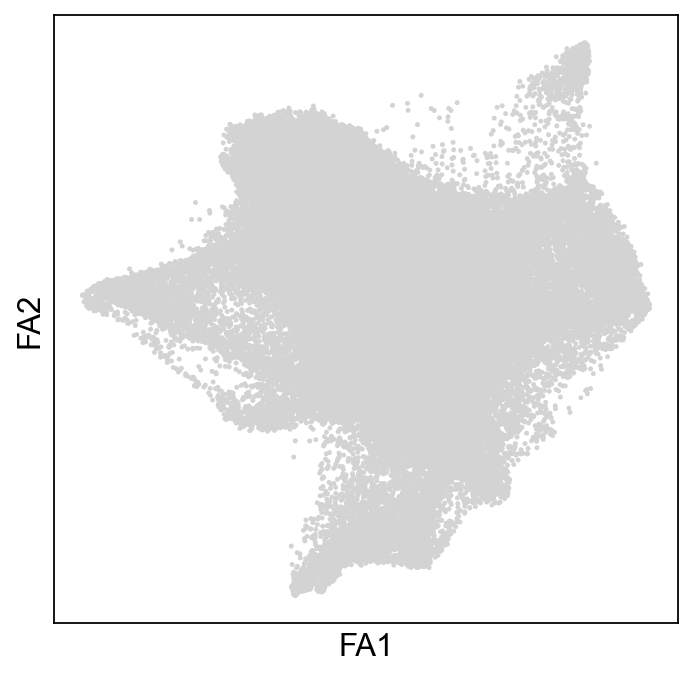

In [59]:
sc.pl.draw_graph(adata_mult_coembed, s=20)

In [79]:
#add metadata
adata_mult_coembed.obs['node_type'] = adata_mult_coembed.obs.index.map(lambda x:"clone" if x[0] == 'c' else 'cell').values
adata_mult_coembed.obs['clone_type'] = adata_mult_coembed.obs.index.map(lambda x:"_".join(x.split("_")[1:]) if len(x.split("_")) == 3 else 'cell').values

In [84]:
clone_table_day = new_table.copy()
clone_table_day_unique = clone_table_day.drop_duplicates(subset='clone_id')
clone_table_day_unique.index = clone_table_day_unique.clone_id
clone_table_day_unique

,cell.bc,edge.den,day,assay,cell_type2,clone.size (RNA & ATAC),# of D2 cells (RNA & ATAC),# of D5 cells (RNA & ATAC),clone.size (RNA),# of D2 cells (RNA),# of D5 cells (RNA),clone.size (ATAC),# of D2 cells (ATAC),# of D5 cells (ATAC),fate,fate_pct,clone_id
clone_id,,,,,,,,,,,,,,,,,
c1_state_atac,d2_5-atac-AAACGAAAGCACGTAG-1,1.000000,d2,atac,MPP/GMP,2,2,0,1,1,0,1,1,0,no_fate_cells,0.0,c1_state_atac
c1_state_rna,d2_5-rna-CAGAGCCGTGCCTACG-1,1.000000,d2,rna,Mono,2,2,0,1,1,0,1,1,0,no_fate_cells,0.0,c1_state_rna
c2_state_atac,d2_5-atac-AAACGAAGTATATGGA-1,0.700000,d2,atac,Neutro,5,1,4,3,0,3,2,1,1,Unk_3,75.0,c2_state_atac
c2_fate_atac,d5_1-atac-AAATGAGCACCCTTAC-1,0.700000,d5,atac,Mono,5,1,4,3,0,3,2,1,1,Unk_3,75.0,c2_fate_atac
c2_fate_rna,d5r1-rna-GCACTAATCGCTCTCA-2,0.700000,d5,rna,Unk_3,5,1,4,3,0,3,2,1,1,Unk_3,75.0,c2_fate_rna
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
c6818_fate_rna,d5r2-rna-TGGTTAGCAGCCGGTT-3,0.666667,d5,rna,Unk_1,3,0,3,3,0,3,0,0,0,Unk_1,100.0,c6818_fate_rna
c6819_fate_rna,d5r2-rna-TGTGATGAGCATCAAA-4,1.000000,d5,rna,Mono,2,0,2,2,0,2,0,0,0,Mono,50.0,c6819_fate_rna
c6820_fate_rna,d5r2-rna-TGTGCGGGTGTACGCC-3,1.000000,d5,rna,Mono,2,0,2,2,0,2,0,0,0,Mono,100.0,c6820_fate_rna


In [85]:
clone_table_day_unique = clone_table_day_unique[['edge.den','fate', 'fate_pct',
       'clone.size (RNA & ATAC)', '# of D2 cells (RNA & ATAC)',
       '# of D5 cells (RNA & ATAC)', 'clone.size (RNA)', '# of D2 cells (RNA)',
       '# of D5 cells (RNA)', 'clone.size (ATAC)', '# of D2 cells (ATAC)',
       '# of D5 cells (ATAC)', 'clone_id']].copy()

In [90]:
#add metadata from clone table 
adata_mult_coembed.obs = adata_mult_coembed.obs.merge(clone_table_day_unique,right_index=True, left_index=True, how="left")

In [29]:
adata_mult_coembed.write_h5ad("../proc_files/lsk_full_coembed_byday_byassay.h5ad")